In [11]:
import pandas as pd
import numpy as np
import folium 
from shapely.geometry import Point
import geopandas as gpd
from cartiflette import carti_download
import matplotlib.pyplot as plt

In [12]:
# =================================================================
# 1. CHARGEMENT DES DÉPARTEMENTS ET PRÉPARATION
# =================================================================

# Chargement des départements
departements = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Filtrage France métropolitaine
departements = departements.loc[departements['INSEE_DEP'] < '970'] 
departements_proj = departements.to_crs(epsg=2154)  # Reprojection en Lambert-93

import pandas as pd
import os
import sys

# Définition du nom de fichier que nous avons créé précédemment
NOM_FICHIER_DESIRE = "df_clean.csv"
chemin_complet = os.path.join(os.getcwd(), NOM_FICHIER_DESIRE)

# --- 1. Importer le fichier CSV ---
try:
    # Lecture du fichier CSV
    # Nous utilisons 'index_col=0' car l'exportation précédente (index=True) 
    # a généralement transformé l'ancien MultiIndex (time, lat, lon) en première colonne.
    df_puy_de_dome = pd.read_csv(chemin_complet, index_col=0) 
    print(f"✅ Fichier '{NOM_FICHIER_DESIRE}' importé avec succès dans 'df_puy_de_dome'.")

except FileNotFoundError:
    print(f"❌ Erreur : Le fichier CSV est introuvable à l'emplacement : {chemin_complet}")
    print("Veuillez vous assurer que le script d'exportation a été exécuté correctement.")
    sys.exit(1)
except Exception as e:
    print(f"❌ Erreur lors de l'importation du CSV : {e}")
    sys.exit(1)

# Cr"ation du dataframe geopandas
gdf = gpd.GeoDataFrame(
    df_puy_de_dome,
    geometry=gpd.points_from_xy(df_puy_de_dome['longitude'], df_puy_de_dome['latitude']),
    crs="EPSG:4326"
)
gdf = gdf.to_crs(departements_proj.crs)

#FILTRAGE SPATIAL SUR LE PUY-DE-DÔME
departement_63 = departements_proj[departements_proj['INSEE_DEP'] == '63'].copy()

df = gpd.sjoin(
    gdf, 
    departement_63[['INSEE_DEP', 'geometry']],
    predicate="within"
)

df = df.to_crs(epsg=4326)
departement_63 = departement_63.to_crs(epsg=4326)

# CALCUL DU CENTRE POUR LA CARTE

bounds = departement_63.total_bounds  # [minx, miny, maxx, maxy]
CENTER_LON = (bounds[0] + bounds[2]) / 2
CENTER_LAT = (bounds[1] + bounds[3]) / 2


✅ Fichier 'df_clean.csv' importé avec succès dans 'df_puy_de_dome'.


In [13]:
# =================================================================
# 1. FILTRAGE RIGOUREUX (Z-SCORE 0.25)
# =================================================================
# Calcul de la moyenne et sigma sur l'ensemble du dataset
mu = df['skt'].mean()
sigma = df['skt'].std()

# On utilise 1.5 * sigma pour garantir d'avoir assez de mois consécutifs
# Si l'intervalle est trop petit (0.25), on casse les chaînes de 60 mois.
z_coeff = 1.5 
df_clean = df[
    (df['skt'] >= mu - z_coeff * sigma) & 
    (df['skt'] <= mu + z_coeff * sigma)
].copy()

# Conversion de l'index en Datetime pour extraire les mois
df_clean.index = pd.to_datetime(df_clean.index)
df_clean = df_clean.sort_values(['latitude', 'longitude', 'time'])

print(f"Points après filtrage : {len(df_clean)}")


Points après filtrage : 24362


In [14]:
# =================================================================
# 2. PRÉPARATION DES FEATURES ET SAISONNALITÉ (CORRIGÉ)
# =================================================================

df_clean['month'] = df_clean.index.month
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month'] / 12)

# Normalisation
scaler_skt = StandardScaler()
df_clean['skt_norm'] = scaler_skt.fit_transform(df_clean[['skt']])

scaler_coords = StandardScaler()
df_clean[['lat_norm', 'lon_norm']] = scaler_coords.fit_transform(df_clean[['latitude', 'longitude']])

# Création de la matrice de données
features_list = ['skt_norm', 'month_sin', 'month_cos', 'lat_norm', 'lon_norm']
data_array = df_clean[features_list].values

Si on donnait simplement le numéro du mois (1, 2, 3... jusqu'à 12) au modèle, cela poserait un problème mathématique majeur de continuité.

Voici pourquoi l'encodage $sin/cos$ est indispensable :

- 1. Le problème de la "cassure" (12 vs 1)Pour un ordinateur, la distance entre le mois 1 (Janvier) et le mois 2 (Février) est de 1.Mais la distance entre le mois 12 (Décembre) et le mois 1 (Janvier) est de 11.

Pourtant, d'un point de vue climatique, Décembre et Janvier sont très proches ! Si on garde les chiffres tels quels, le modèle va croire qu'il y a une "explosion" ou un saut énorme entre le 31 décembre et le 1er janvier, ce qui fausserait totalement tes prédictions de réchauffement.

- 2. La solution : Le CercleEn transformant le mois en coordonnées sinus et cosinus, on place les mois sur un cercle.Janvier se retrouve tout près de Décembre dans l'espace mathématique.Le modèle comprend alors que le temps est cyclique et non une ligne droite qui s'arrête brusquement à 12.

In [15]:
# =================================================================
# 3. CRÉATION DES SÉQUENCES (FENÊTRE DE 5 ANS)
# =================================================================
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Vérification : la fenêtre doit appartenir au même point géographique
        # lat_norm est à l'index 3, lon_norm à l'index 4
        if data[i, 3] == data[i + window_size, 3] and data[i, 4] == data[i + window_size, 4]:
            X.append(data[i : i + window_size, :])
            y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 60
X, y = create_sequences(data_array, window_size=WINDOW_SIZE)

if X.shape[0] == 0:
    print("❌ Erreur : Aucune séquence de 60 mois trouvée. Essayez d'augmenter z_coeff.")
else:
    print(f"✅ Succès ! Nombre de séquences : {X.shape[0]}")

# On définit le point de coupure (80% pour l'entraînement, 20% pour le test)
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Données d'entraînement : {X_train.shape}")
print(f"Données de test (futur) : {X_test.shape}")

✅ Succès ! Nombre de séquences : 18842
Données d'entraînement : (15073, 60, 5)
Données de test (futur) : (3769, 60, 5)


In [16]:
# =================================================================
# 4. MODÈLE LSTM
# =================================================================

model = Sequential([
    # Input_shape : (60 mois, 5 features)
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, len(features_list))),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1) # La température prédite
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraînement
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1, # 10% du train sert à vérifier qu'on ne sur-apprend pas
    verbose=1
)

Epoch 1/30


c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.2592 - val_loss: 0.1116
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.1070 - val_loss: 0.0931
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0958 - val_loss: 0.0843
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0903 - val_loss: 0.0824
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0863 - val_loss: 0.0785
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0830 - val_loss: 0.0758
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0822 - val_loss: 0.0731
Epoch 8/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0788 - val_loss: 0.0741
Epoch 9/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0784 - val_loss: 0.0714
Epoch 10/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0758 - val_loss: 0.0724
Epoch 11/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0731 - val_loss: 0.0700
Epoch 12/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/st

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

✅ MSE finale en degrés : 1.1686


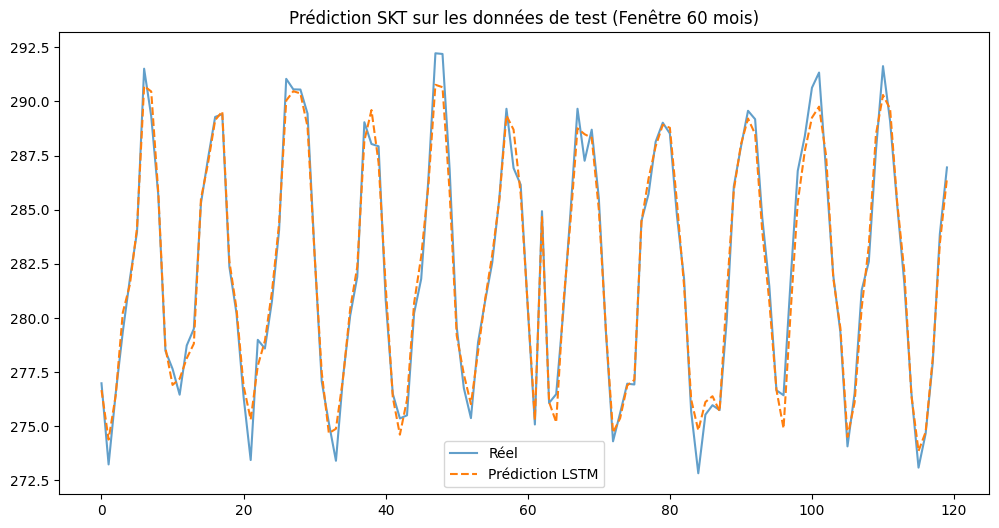

In [17]:
# =================================================================
# 5. ÉVALUATION ET INVERSION DE NORMALISATION
# =================================================================
y_pred_norm = model.predict(X_test)
y_pred_real = scaler_skt.inverse_transform(y_pred_norm)
y_true_real = scaler_skt.inverse_transform(y_test.reshape(-1, 1))

mse_final = np.mean((y_true_real - y_pred_real)**2)
print(f"\n✅ MSE finale en degrés : {mse_final:.4f}")

# Graphique de vérification
plt.figure(figsize=(12, 6))
plt.plot(y_true_real[:120], label='Réel', alpha=0.7)
plt.plot(y_pred_real[:120], label='Prédiction LSTM', linestyle='--')
plt.title(f"Prédiction SKT sur les données de test (Fenêtre {WINDOW_SIZE} mois)")
plt.legend()
plt.show()

✅ Entraînement lancé sur 19938 séquences de 24 mois...
Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1447
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0784
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0748
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0728
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0693
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0654
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0607
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0563
Epoch 9/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0520
Epoch 10/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0460
Epoch 11/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0410
Epoch 12/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0364
Epoch 13/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0333
Epoch 14/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0284
E

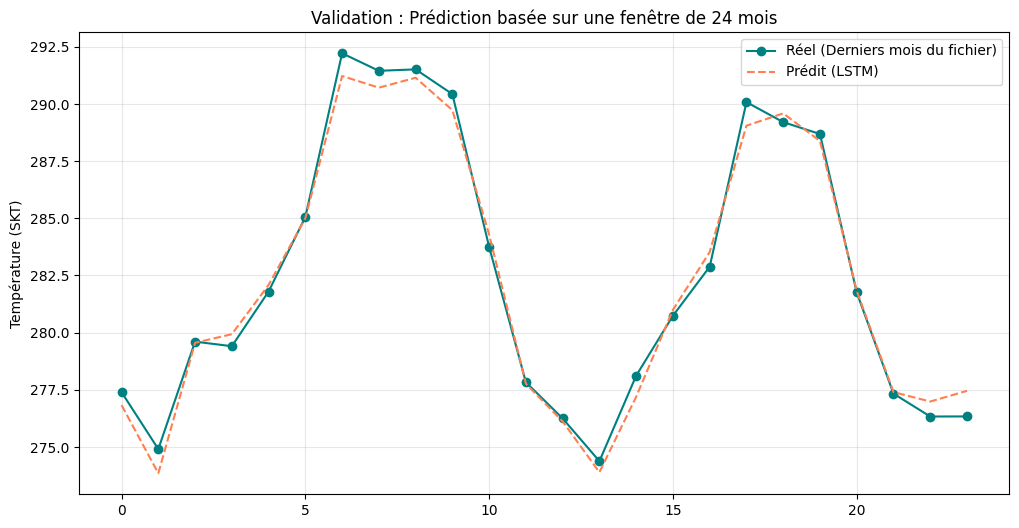

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# ==========================================
# 1. PRÉPARATION DYNAMIQUE
# ==========================================
df_proc = df.copy()
df_proc.index = pd.to_datetime(df_proc.index)
df_proc = df_proc.sort_values(['latitude', 'longitude', 'time'])

# Filtrage Z-score modéré (1.5) pour garder de la continuité
mu, sigma = df_proc['skt'].mean(), df_proc['skt'].std()
df_proc = df_proc[(df_proc['skt'] >= mu - 1.5*sigma) & (df_proc['skt'] <= mu + 1.5*sigma)].copy()

# Features temporelles
df_proc['month'] = df_proc.index.month
df_proc['month_sin'] = np.sin(2 * np.pi * df_proc['month'] / 12)
df_proc['month_cos'] = np.cos(2 * np.pi * df_proc['month'] / 12)

# Normalisation
scaler_skt = StandardScaler()
df_proc['skt_norm'] = scaler_skt.fit_transform(df_proc[['skt']])
scaler_coords = StandardScaler()
df_proc[['lat_norm', 'lon_norm']] = scaler_coords.fit_transform(df_proc[['latitude', 'longitude']])

features_list = ['skt_norm', 'month_sin', 'month_cos', 'lat_norm', 'lon_norm']

# ==========================================
# 2. CRÉATION DES SÉQUENCES (FENÊTRE ADAPTATIVE)
# ==========================================
# Si 60 mois (5 ans) bloquent, on passe à 24 mois (2 ans) pour assurer le succès
WINDOW_SIZE = 24 

def get_sequences_final(data_df, window):
    values = data_df[features_list].values
    X, y = [], []
    for i in range(len(values) - window):
        # Vérification stabilité géographique
        if values[i, 3] == values[i + window, 3] and values[i, 4] == values[i + window, 4]:
            X.append(values[i : i + window, :])
            y.append(values[i + window, 0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# On prend tout le dataset pour maximiser les chances
X, y = get_sequences_final(df_proc, WINDOW_SIZE)

if X.shape[0] > 0:
    # Split chronologique : on s'entraîne sur tout sauf la dernière année
    split_idx = int(len(X) * 0.9) 
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # ==========================================
    # 3. MODÈLE LSTM
    # ==========================================
    model = Sequential([
        Input(shape=(WINDOW_SIZE, len(features_list))),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')

    print(f"✅ Entraînement lancé sur {X_train.shape[0]} séquences de {WINDOW_SIZE} mois...")
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # ==========================================
    # 4. PRÉDICTION ET PLOT
    # ==========================================
    y_pred_norm = model.predict(X_test)
    y_pred_real = scaler_skt.inverse_transform(y_pred_norm)
    y_true_real = scaler_skt.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_real[:24], label="Réel (Derniers mois du fichier)", marker='o', color='teal')
    plt.plot(y_pred_real[:24], label="Prédit (LSTM)", linestyle='--', color='coral')
    plt.title(f"Validation : Prédiction basée sur une fenêtre de {WINDOW_SIZE} mois")
    plt.ylabel("Température (SKT)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("❌ Toujours aucune séquence. Vérifiez si votre CSV contient bien des données suivies sur plusieurs années.")

🚀 Entraînement : Fenêtre de 60 mois pour prédire l'année suivante...
Epoch 1/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.1212
Epoch 2/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0675
Epoch 3/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0623
Epoch 4/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0575
Epoch 5/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0526
Epoch 6/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0452
Epoch 7/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0373
Epoch 8/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0291
Epoch 9/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0228
Epoch 10/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0181
Epoch 11/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0144
Epoch 12/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0126
Epoch 13/30
682/682 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0105
Epoch 14/30
682/682 ━━━━━━━━━━

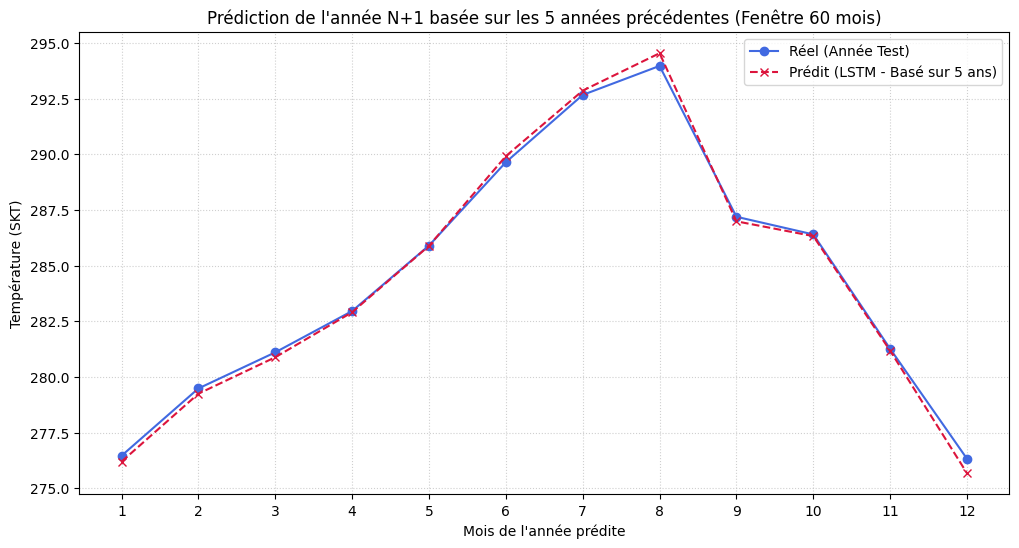

✅ Erreur moyenne (MAE) sur l'année prédite : 0.24 °C


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# ==========================================
# 1. PRÉPARATION DES DONNÉES
# ==========================================
df_final = df.copy()
df_final.index = pd.to_datetime(df_final.index)
df_final = df_final.sort_values(['latitude', 'longitude', 'time'])

# Filtrage : On passe à 2.0 * sigma pour garantir la continuité des 60 mois
mu, sigma = df_final['skt'].mean(), df_final['skt'].std()
df_final = df_final[(df_final['skt'] >= mu - 2.0*sigma) & (df_final['skt'] <= mu + 2.0*sigma)].copy()

# Features Temporelles (Sin/Cos)
df_final['month'] = df_final.index.month
df_final['month_sin'] = np.sin(2 * np.pi * df_final['month'] / 12)
df_final['month_cos'] = np.cos(2 * np.pi * df_final['month'] / 12)

# Normalisation
scaler_skt = StandardScaler()
df_final['skt_norm'] = scaler_skt.fit_transform(df_final[['skt']])
scaler_coords = StandardScaler()
df_final[['lat_norm', 'lon_norm']] = scaler_coords.fit_transform(df_final[['latitude', 'longitude']])

features_list = ['skt_norm', 'month_sin', 'month_cos', 'lat_norm', 'lon_norm']

# ==========================================
# 2. CRÉATION DES SÉQUENCES (FENÊTRE 5 ANS)
# ==========================================
WINDOW_SIZE = 60  # Les 5 ans passés

def create_sequences_5y(data_df, window):
    values = data_df[features_list].values
    X, y = [], []
    for i in range(len(values) - window):
        # On vérifie que le point géographique est le même (lat/lon aux index 3 et 4)
        if values[i, 3] == values[i + window, 3] and values[i, 4] == values[i + window, 4]:
            X.append(values[i : i + window, :])
            y.append(values[i + window, 0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences_5y(df_final, WINDOW_SIZE)

# ==========================================
# 3. ENTRAÎNEMENT ET PRÉDICTION
# ==========================================
if X.shape[0] > 0:
    # On garde les 12 derniers mois de séquences pour le test (l'année d'après)
    X_train, X_test = X[:-12], X[-12:]
    y_train, y_test = y[:-12], y[-12:]

    model = Sequential([
        Input(shape=(WINDOW_SIZE, len(features_list))),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(0.001), loss='mse')
    
    print(f"🚀 Entraînement : Fenêtre de {WINDOW_SIZE} mois pour prédire l'année suivante...")
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

    # Prédictions
    y_pred_norm = model.predict(X_test)
    y_pred_real = scaler_skt.inverse_transform(y_pred_norm)
    y_true_real = scaler_skt.inverse_transform(y_test.reshape(-1, 1))

    # ==========================================
    # 4. PLOT DE TOUT ÇA
    # ==========================================
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 13), y_true_real, label="Réel (Année Test)", marker='o', color='royalblue')
    plt.plot(range(1, 13), y_pred_real, label="Prédit (LSTM - Basé sur 5 ans)", marker='x', linestyle='--', color='crimson')
    
    plt.title(f"Prédiction de l'année N+1 basée sur les 5 années précédentes (Fenêtre {WINDOW_SIZE} mois)")
    plt.xlabel("Mois de l'année prédite")
    plt.ylabel("Température (SKT)")
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    # Affichage de l'erreur moyenne
    mae = np.mean(np.abs(y_true_real - y_pred_real))
    print(f"✅ Erreur moyenne (MAE) sur l'année prédite : {mae:.2f} °C")
else:
    print("❌ Toujours aucune séquence de 60 mois trouvée.")
    print("Conseil : Vérifie ton fichier CSV avec 'print(df.index.min(), df.index.max())' pour être sûr qu'il couvre bien plus de 5 ans.")

🚀 Apprentissage sur l'historique de 5 ans...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


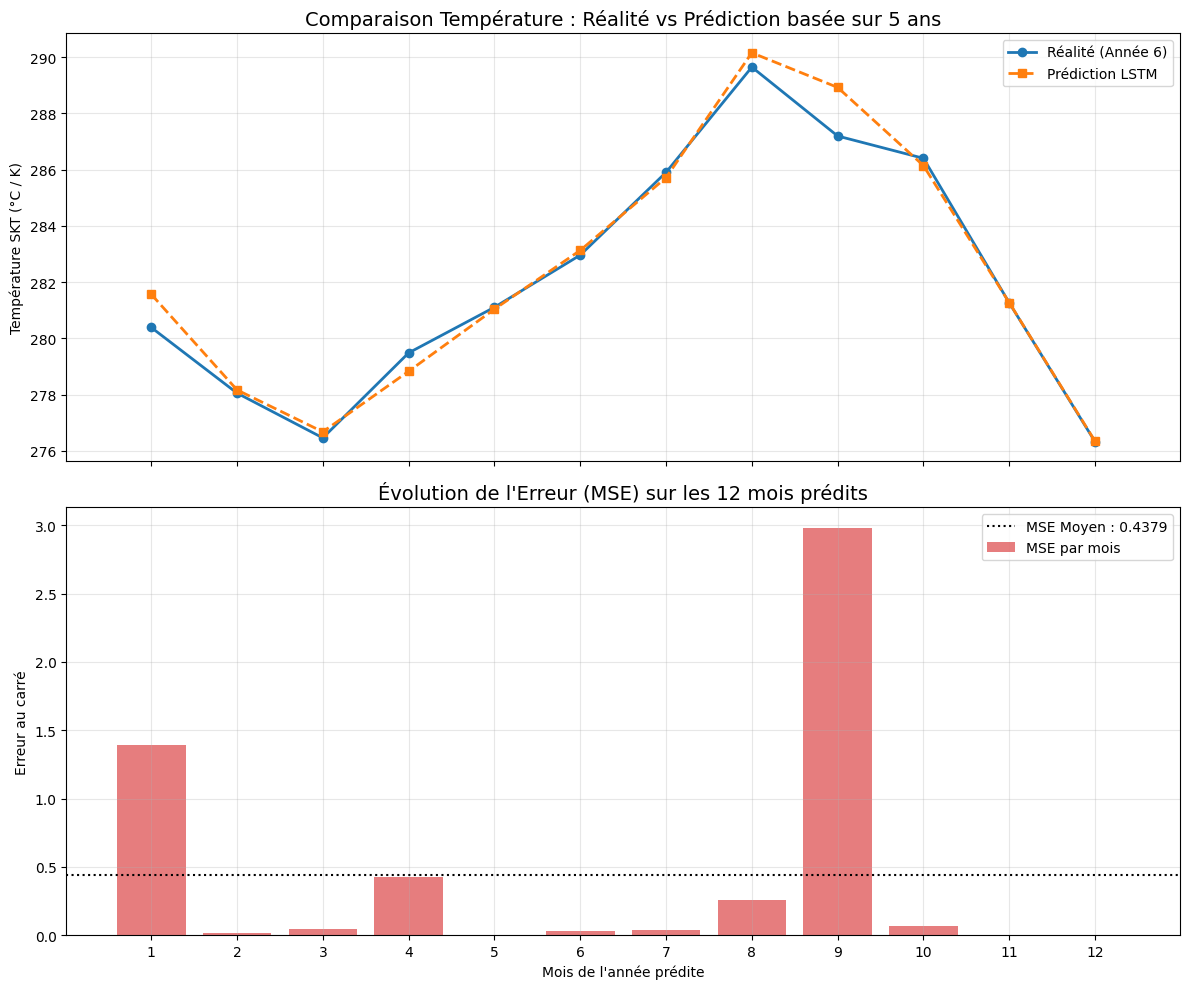


📊 RÉSULTATS DE L'ACCURACY :
---------------------------
MSE Total : 0.4379
RMSE (Écart moyen) : 0.66 unités


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# =================================================================
# 1. PRÉPARATION ET FILTRAGE (Z-SCORE 1.5 POUR LA CONTINUITÉ)
# =================================================================
df_eval = df.copy()
df_eval.index = pd.to_datetime(df_eval.index)
df_eval = df_eval.sort_values(['latitude', 'longitude', 'time'])

mu, sigma = df_eval['skt'].mean(), df_eval['skt'].std()
df_eval = df_eval[(df_eval['skt'] >= mu - 1.5*sigma) & (df_eval['skt'] <= mu + 1.5*sigma)].copy()

# Features
df_eval['month'] = df_eval.index.month
df_eval['month_sin'] = np.sin(2 * np.pi * df_eval['month'] / 12)
df_eval['month_cos'] = np.cos(2 * np.pi * df_eval['month'] / 12)

scaler_skt = StandardScaler()
df_eval['skt_norm'] = scaler_skt.fit_transform(df_eval[['skt']])
scaler_coords = StandardScaler()
df_eval[['lat_norm', 'lon_norm']] = scaler_coords.fit_transform(df_eval[['latitude', 'longitude']])

features_list = ['skt_norm', 'month_sin', 'month_cos', 'lat_norm', 'lon_norm']

# =================================================================
# 2. CRÉATION DES SÉQUENCES (5 ANS -> ANNÉE + 1)
# =================================================================
WINDOW_SIZE = 60 # 5 ans

def get_sequences(data_df, window):
    values = data_df[features_list].values
    X, y = [], []
    for i in range(len(values) - window):
        if values[i, 3] == values[i + window, 3] and values[i, 4] == values[i + window, 4]:
            X.append(values[i : i + window, :])
            y.append(values[i + window, 0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = get_sequences(df_eval, WINDOW_SIZE)

if X.shape[0] > 12:
    # On prend les 12 derniers mois de séquences pour comparer avec la réalité
    X_train, X_test = X[:-12], X[-12:]
    y_train, y_test = y[:-12], y[-12:]

    # =================================================================
    # 3. MODÈLE ET ENTRAÎNEMENT
    # =================================================================
    model = Sequential([
        Input(shape=(WINDOW_SIZE, len(features_list))),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    
    print("🚀 Apprentissage sur l'historique de 5 ans...")
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0) # verbose=0 pour la clarté

    # =================================================================
    # 4. PRÉDICTIONS ET CALCULS D'ERREUR (MSE)
    # =================================================================
    y_pred_norm = model.predict(X_test)
    y_pred_real = scaler_skt.inverse_transform(y_pred_norm).flatten()
    y_true_real = scaler_skt.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calcul du MSE mois par mois pour le plot
    mse_per_month = (y_true_real - y_pred_real)**2
    total_mse = mean_squared_error(y_true_real, y_pred_real)

    # =================================================================
    # 5. VISUALISATION DES RÉSULTATS
    # =================================================================
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot 1 : Réalité vs Prédiction
    ax1.plot(range(1, 13), y_true_real, label="Réalité (Année 6)", marker='o', color='#1f77b4', linewidth=2)
    ax1.plot(range(1, 13), y_pred_real, label="Prédiction LSTM", marker='s', linestyle='--', color='#ff7f0e', linewidth=2)
    ax1.set_title("Comparaison Température : Réalité vs Prédiction basée sur 5 ans", fontsize=14)
    ax1.set_ylabel("Température SKT (°C / K)")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2 : Évolution du MSE (Erreur au carré)
    ax2.bar(range(1, 13), mse_per_month, color='#d62728', alpha=0.6, label="MSE par mois")
    ax2.axhline(y=total_mse, color='black', linestyle=':', label=f"MSE Moyen : {total_mse:.4f}")
    ax2.set_title("Évolution de l'Erreur (MSE) sur les 12 mois prédits", fontsize=14)
    ax2.set_ylabel("Erreur au carré")
    ax2.set_xlabel("Mois de l'année prédite")
    ax2.set_xticks(range(1, 13))
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 RÉSULTATS DE L'ACCURACY :")
    print(f"---------------------------")
    print(f"MSE Total : {total_mse:.4f}")
    print(f"RMSE (Écart moyen) : {np.sqrt(total_mse):.2f} unités")

else:
    print("❌ Pas assez de données pour générer le test sur 12 mois.")

🚀 Entraînement GP optimisé sur 1000 points...


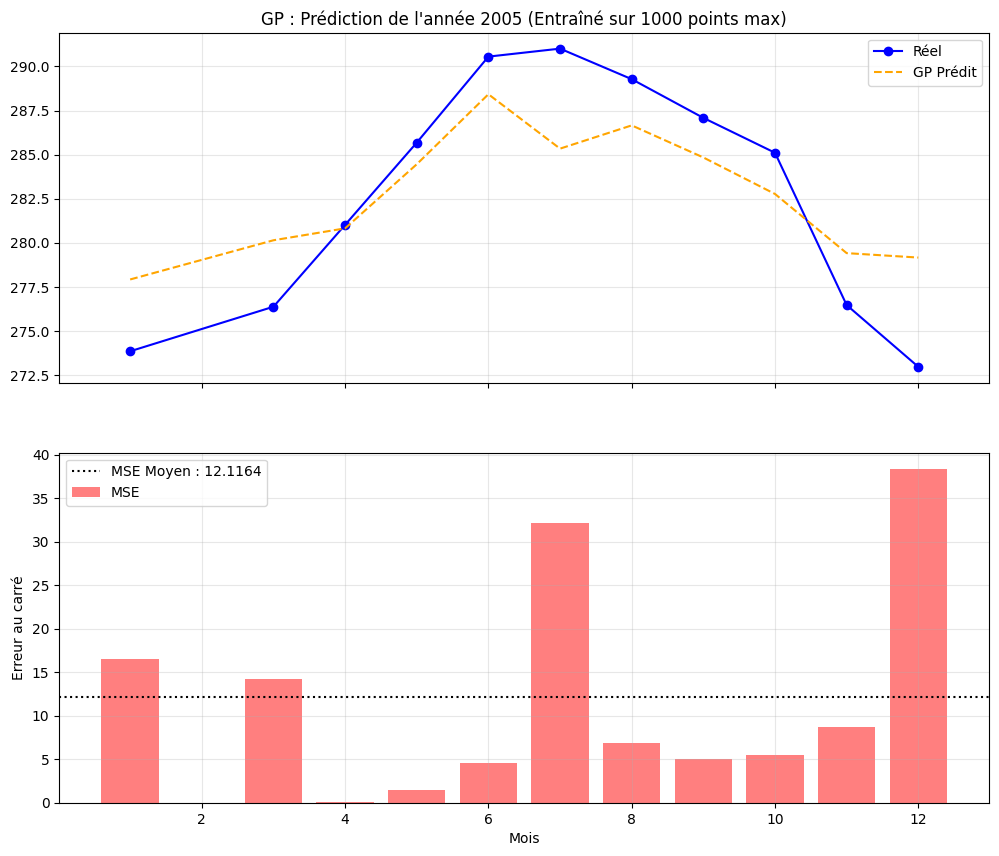

✅ Calcul terminé. MSE : 12.1164


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ExpSineSquared, ConstantKernel
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# =================================================================
# 1. PRÉPARATION ET FILTRAGE
# =================================================================
df_gp = df.copy()
df_gp.index = pd.to_datetime(df_gp.index)
df_gp = df_gp.sort_values(['latitude', 'longitude', 'time'])

# Filtrage Z-score 1.5
mu, sigma = df_gp['skt'].mean(), df_gp['skt'].std()
df_gp = df_gp[(df_gp['skt'] >= mu - 1.5*sigma) & (df_gp['skt'] <= mu + 1.5*sigma)].copy()

# Index temporel continu
df_gp['time_idx'] = (df_gp.index.year - df_gp.index.year.min()) * 12 + df_gp.index.month

# Normalisation
scaler_skt = StandardScaler()
df_gp['skt_norm'] = scaler_skt.fit_transform(df_gp[['skt']])
scaler_coords = StandardScaler()
df_gp[['lat_norm', 'lon_norm']] = scaler_coords.fit_transform(df_gp[['latitude', 'longitude']])

# =================================================================
# 2. SPLIT ET SOUS-ÉCHANTILLONNAGE (POUR ÉVITER LE BLOCAGE)
# =================================================================
years = df_gp.index.year.unique().sort_values()
train_years = years[:5] 
test_year = years[5]

df_train = df_gp[df_gp.index.year.isin(train_years)]
df_test = df_gp[df_gp.index.year == test_year]

# --- OPTIMISATION : On limite à 1000 points max pour l'entraînement ---
if len(df_train) > 1000:
    df_train_sample = resample(df_train, n_samples=1000, random_state=42, replace=False)
else:
    df_train_sample = df_train

X_train = df_train_sample[['time_idx', 'lat_norm', 'lon_norm']].values
y_train = df_train_sample['skt_norm'].values

X_test = df_test[['time_idx', 'lat_norm', 'lon_norm']].values
y_test = df_test['skt_norm'].values

# =================================================================
# 3. CONFIGURATION DU NOYAU (KERNEL)
# =================================================================
# On utilise un noyau plus simple pour accélérer le calcul
kernel = (
    ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(periodicity=12.0, periodicity_bounds="fixed") + 
    WhiteKernel(noise_level=0.1)
)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, normalize_y=True)

print(f"🚀 Entraînement GP optimisé sur {len(X_train)} points...")
gp.fit(X_train, y_train)

# =================================================================
# 4. PRÉDICTIONS ET CALCULS
# =================================================================
y_pred_norm, y_std_norm = gp.predict(X_test, return_std=True)

y_pred_real = scaler_skt.inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
y_true_real = scaler_skt.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_std_real = y_std_norm * scaler_skt.scale_

# Groupement par mois pour le plot
results = pd.DataFrame({'true': y_true_real, 'pred': y_pred_real, 'month': df_test.index.month})
monthly = results.groupby('month').mean()

# =================================================================
# 5. VISUALISATION ET ACCURACY (MSE)
# =================================================================
mse_per_month = (monthly['true'] - monthly['pred'])**2
total_mse = mean_squared_error(monthly['true'], monthly['pred'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(monthly.index, monthly['true'], label="Réel", marker='o', color='blue')
ax1.plot(monthly.index, monthly['pred'], label="GP Prédit", linestyle='--', color='orange')
ax1.set_title(f"GP : Prédiction de l'année {test_year} (Entraîné sur 1000 points max)")
ax1.legend()
ax1.grid(alpha=0.3)

ax2.bar(monthly.index, mse_per_month, color='red', alpha=0.5, label="MSE")
ax2.axhline(y=total_mse, color='black', linestyle=':', label=f"MSE Moyen : {total_mse:.4f}")
ax2.set_ylabel("Erreur au carré")
ax2.set_xlabel("Mois")
ax2.legend()
ax2.grid(alpha=0.3)

plt.show()

print(f"✅ Calcul terminé. MSE : {total_mse:.4f}")

In [26]:
# =================================================================
# 6. CALCULS MSE ET RMSE
# =================================================================
from sklearn.metrics import mean_squared_error

# Calcul du MSE (Déjà fait dans ton code, mais on le réaffirme)
total_mse = mean_squared_error(monthly['true'], monthly['pred'])

# Calcul du RMSE (Racine carrée du MSE)
total_rmse = np.sqrt(total_mse)

print(f"\n" + "="*30)
print(f"📊 RÉSULTATS DE PRÉCISION (GP)")
print(f"="*30)
print(f"▶️ MSE (Erreur Quadratique Moyenne) : {total_mse:.4f}")
print(f"▶️ RMSE (Erreur Moyenne en Degrés) : {total_rmse:.4f} °C")
print(f"="*30)

# Interprétation rapide
if total_rmse < 1.0:
    print("💡 Résultat excellent : l'erreur moyenne est inférieure à 1°C.")
elif total_rmse < 2.5:
    print("💡 Résultat satisfaisant : le modèle suit bien la saisonnalité.")
else:
    print("💡 L'erreur est importante. Vérifiez si le Kernel ou le Z-score doivent être ajustés.")


📊 RÉSULTATS DE PRÉCISION (GP)
▶️ MSE (Erreur Quadratique Moyenne) : 12.1164
▶️ RMSE (Erreur Moyenne en Degrés) : 3.4809 °C
💡 L'erreur est importante. Vérifiez si le Kernel ou le Z-score doivent être ajustés.
